In [38]:
RES_EVAL = 1000
test_file = "test_quat_onekey"
sampler = 'resample_dense'

In [39]:
import os, UnityPy
from UnityPy.enums import ClassIDType
from sssekai.unity.AnimationClip import AnimationHelper, kBindTransformRotation, as_floats
SAMPLE_FILE = lambda *args: os.path.join(os.path.abspath(''), *args)

EPS = 1e-6

from matplotlib import pyplot as plt
import numpy as np

# ix + jy + kz + w  
def norm_sq(quat):
    return quat[0]**2 + quat[1]**2 + quat[2]**2 + quat[3]**2
def conjugate(quat):   
    return np.array([-quat[0], -quat[1], -quat[2], quat[3]])
def inverse(quat):
    return conjugate(quat) / norm_sq(quat)
def mul(q,r):
    qv, rv = q[:3], r[:3]
    qw, rw = q[3], r[3]
    v = np.cross(qv, rv) + rw * qv + qw * rv
    w = rw * qw - np.dot(qv, rv)
    return np.array([v[0], v[1], v[2], w])

In [40]:
env = UnityPy.load(SAMPLE_FILE("animation_plot", test_file))
anim = next(filter(lambda x: x.type == ClassIDType.AnimationClip, env.objects))
anim = AnimationHelper.from_clip(anim.read())

In [41]:
def run_once(RES_RESAMPLE):
    times = lambda res:[t / res for t in range(0, int(res))]

    curve = anim.Curves[kBindTransformRotation][0]
    curve_dense = getattr(curve,sampler)(times(RES_RESAMPLE))

    eval_t = np.array(times(RES_EVAL))

    eval = np.array([as_floats(curve_dense.evaluate(t)) for t in eval_t])
    eval_inv = np.array([inverse(quat) for quat in eval])

    target = np.array([as_floats(curve.evaluate(t)) for t in eval_t])

    loss = np.array([mul(t, e) for t, e in zip(target, eval_inv)])
    loss_cos = np.array([l[3] for l in loss]) 
    loss_rad = np.arccos(np.clip(loss_cos, -1.0 + EPS, 1.0 - EPS))
    loss_deg = np.degrees(loss_rad)
    print(f'loss (degrees): {np.linalg.norm(loss_deg)}')
    print(f'loss max= {np.max(loss_deg)}')
    print(f'loss mean= {np.mean(loss_deg)}')

    plt.plot(eval_t, loss_deg, label="Loss (degrees)")
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.legend()
    plt.show()

loss (degrees): 446.7848812065407
loss max= 41.33682912134209
loss mean= 7.63209625654594


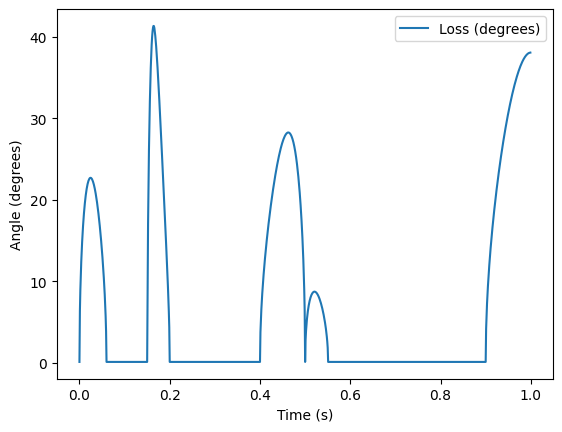

In [42]:
run_once(10)

loss (degrees): 32.78996673669511
loss max= 4.979805373066965
loss mean= 0.46181513469168245


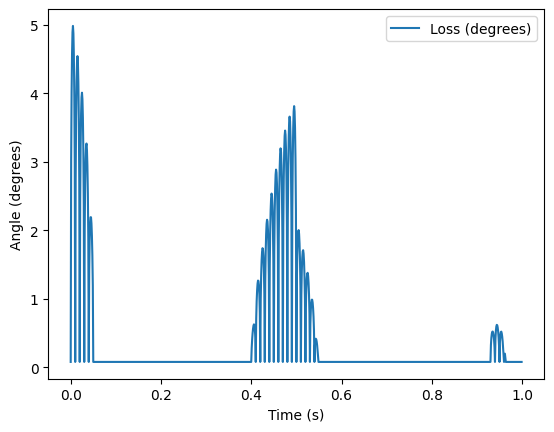

In [43]:
run_once(100)

loss (degrees): 6.183720731100603
loss max= 1.0284286386195984
loss mean= 0.12419015963042035


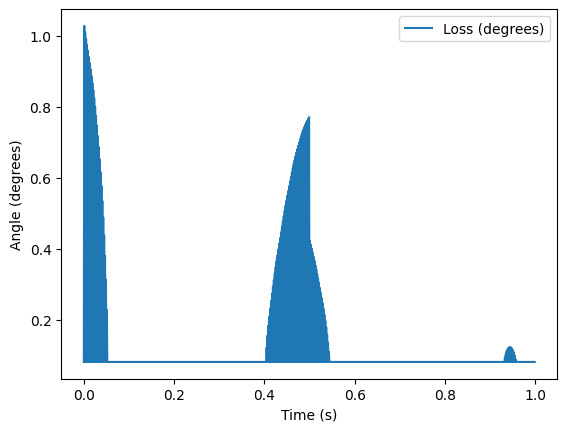

In [44]:
run_once(500)

loss (degrees): 2.5623453698674883
loss max= 0.08102847520767846
loss mean= 0.08102847520767845


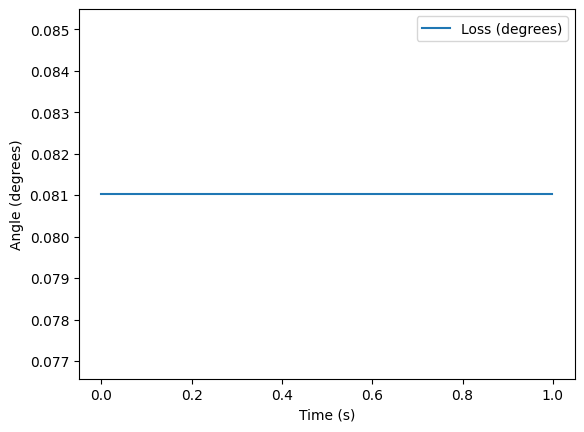

In [45]:
run_once(1000)